In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
from numba import njit

In [2]:
# Please see process_L2 in https://github.com/nkaz001/data-tardis/blob/master/tardis-process.ipynb
#
# x[0] price of a level in the order book
# x[1] quantity of a level in the order book
#
# buy = sum(map(lambda x: x[1], filter(lambda x: x[0] > mid * (1 - p), bid.iteritems())))
# sell = sum(map(lambda x: x[1], filter(lambda x: x[0] < mid * (1 + p), ask.iteritems())))
# imbalance = standardize(buy - sell, 1-day)
# 
# When not considering skew, this strategy does 
# Buy if imbalance is greater than a given threshold +T
# Sell if imbalance is less than a given threshold -T

In [3]:
df = pd.read_pickle('btcusdt_data')
df.iloc[:, 7:] = (df.iloc[:, 7:] - df.iloc[:, 7:].rolling('1d').mean()) / df.iloc[:, 7:].rolling('1d').std()  # 1-day rolling

In [4]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'best_bid', 'best_ask',
       '0.5%', '0.75%', '1%', '1.25%', '1.5%', '1.75%', '2%', '2.5%', '3%',
       '3.5%', '4%', '4.5%', '5%'],
      dtype='object')

In [5]:
df.iloc[-25000:]

,open,high,low,close,volume,best_bid,best_ask,0.5%,0.75%,1%,1.25%,1.5%,1.75%,2%,2.5%,3%,3.5%,4%,4.5%,5%
timestamp,,,,,,,,,,,,,,,,,,,,
2022-08-30 13:16:45,20364.800781,20365.400391,20364.800781,20365.400391,8.278,20365.3,20365.4,-0.541412,0.290287,0.341093,0.231048,-0.500803,-0.750378,-0.909639,-0.721155,-0.938307,-0.993487,-1.014898,-0.970765,-1.040268
2022-08-30 13:16:50,20365.300781,20365.400391,20365.300781,20365.300781,3.690,20365.3,20365.4,-0.610324,0.249942,0.314904,0.203755,-0.518881,-0.771396,-0.931394,-0.745020,-0.967282,-1.026225,-1.052281,-1.009420,-1.094019
2022-08-30 13:16:55,20365.300781,20365.300781,20365.099609,20365.199219,8.805,20365.1,20365.2,-0.733156,0.187077,0.332361,0.230061,-0.531132,-0.796108,-0.946130,-0.768331,-0.990003,-1.059549,-1.094898,-1.053234,-1.135031
2022-08-30 13:17:00,20365.099609,20365.199219,20360.599609,20360.599609,8.127,20361.0,20361.4,-1.132968,0.127404,0.256263,0.212633,-0.569584,-0.843460,-0.993108,-0.828728,-1.102934,-1.190535,-1.225435,-1.223599,-1.276276
2022-08-30 13:17:05,20360.699219,20360.699219,20360.099609,20360.099609,17.513,20360.1,20360.2,-0.461476,0.520985,0.567078,0.429837,0.125261,-0.703878,-0.845615,-0.683261,-0.885783,-0.984887,-0.986643,-0.972758,-1.068452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 23:59:40,20047.300781,20047.400391,20047.300781,20047.300781,22.341,20047.3,20047.4,-0.077314,0.567482,0.646206,1.111399,0.920229,1.171202,1.033650,1.512420,1.568157,1.161733,1.185406,1.464893,1.470008
2022-08-31 23:59:45,20047.400391,20047.400391,20047.300781,20047.400391,6.532,20047.3,20047.4,-0.180741,0.505139,0.609005,1.081004,0.877830,1.117341,0.989715,1.471543,1.526153,1.114379,1.129760,1.401439,1.399201
2022-08-31 23:59:50,20047.400391,20047.400391,20043.800781,20045.500000,23.227,20045.5,20045.6,-0.141483,0.561921,0.707107,1.168237,0.915423,1.135240,1.031095,1.499576,1.545091,1.130974,1.145754,1.424533,1.428034


In [6]:
@njit
def predict_njit(fee_, A, B, half_spread, max_position, X, imbalance):
    tick_size = 0.01
    running_qty = 0
    static_equity = 0
    fee = 0
    equity = []
    running_qty_ = []
    order_qty = 10000
    order_qty_btc = 0
    new_bid = np.nan
    new_ask = np.nan
    high = 1
    low = 2
    close = 3
    volume = 4
    best_bid = 5
    best_ask = 6
    for row in X:
        # Check if the orders are filled:
        # the bid order is considered filled if a trade happened below the order price.
        # the ask order is considered filled if a trade happened above the order price.
        # 
        #if np.isfinite(new_bid) \
        #    and (int(round(new_bid / tick_size)) < int(round(row[low] / tick_size)) or int(round(new_bid / tick_size) >= row[best_ask])) \
        #    and row[volume] > 0:
        if np.isfinite(new_bid) \
            and int(round(new_bid / tick_size)) > int(round(row[low] / tick_size)) \
            and row[volume] > 0:
            running_qty += order_qty_btc
            static_equity -= order_qty_btc * new_bid
            fee += order_qty_btc * new_bid * fee_    
        #if np.isfinite(new_ask) \
        #    and (int(round(new_ask / tick_size)) < int(round(row[high] / tick_size)) or int(round(new_ask / tick_size) <= row[best_bid])) \
        #    and row[volume] > 0:
        if np.isfinite(new_ask) \
            and int(round(new_ask / tick_size)) < int(round(row[high] / tick_size)) \
            and row[volume] > 0:
            running_qty -= order_qty_btc
            static_equity += order_qty_btc * new_ask
            fee += order_qty_btc * new_ask * fee_
        equity.append(static_equity + running_qty * row[close] - fee)
        running_qty_.append(running_qty)
        x = running_qty * row[close] # in $
        skew = B * x / max_position * -1
        quote_mid_price = row[close] + A * row[imbalance] + skew
        # Limit the price of orders to best bid/ask in order not to take liquidity. (Due to fee)
        new_bid = np.minimum(np.minimum(np.round(quote_mid_price * (1 - half_spread) / tick_size) * tick_size, row[close] - tick_size), row[best_bid])
        new_ask = np.maximum(np.maximum(np.round(quote_mid_price * (1 + half_spread) / tick_size) * tick_size, row[close] + tick_size), row[best_ask])
        order_qty_btc = np.maximum(np.round(order_qty / row[close], 3), 0.001)
        # The maximum position size is fixed in Dollar.
        if x > max_position:
            new_bid = np.nan
        if x < -max_position:
            new_ask = np.nan
    return equity, running_qty_

class Backtest:
    def __init__(self, fee=None, max_position=None, A=None, B=None, half_spread=None, imbalance=None):
        self.fee = fee
        self.max_position = max_position
        self.A = A
        self.B = B
        self.half_spread = half_spread
        self.imbalance = imbalance
        
    def set_params(self, A, B, half_spread, imbalance):
        self.A = A
        self.B = B
        self.half_spread = half_spread
        self.imbalance = imbalance
        return self
        
    def get_params(self, deep=True):
        return { 'fee': self.fee, 'max_position': self.max_position, 'A': self.A, 'B': self.B, 'half_spread': self.half_spread, 'imbalance': self.imbalance }
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        equity, running_qty = predict_njit(self.fee, self.A, self.B, self.half_spread, self.max_position, X, self.imbalance)
        return equity, running_qty
    
    def score(self, X):
        equity, _ = self.predict(X)
        returns = (pd.Series(equity).diff() / self.max_position).fillna(0)
#         bm_returns = pd.Series(X[:, 3]).pct_change().fillna(0)
#         returns_ = returns - bm_returns
        return np.divide(returns.mean(), returns.std())

In [7]:
train = df[(df.index >= '2021-1-1') & (df.index < '2022-1-1')]
valid = df[df.index < '2021-1-1']

In [8]:
param_dist = { 'A': stats.uniform(1, 100), 'B': stats.uniform(1, 100), 'half_spread': stats.uniform(0, 0.001), 'imbalance': np.arange(7, 19) }
search = RandomizedSearchCV(Backtest(0.0002, 1000000),
                            cv=[(np.arange(len(train)), np.arange(len(train)))],
                            param_distributions=param_dist,
                            verbose=1,
                            n_iter=1000,
                            n_jobs=8)
search.fit(train.values)

Fitting 1 folds for each of 1000 candidates, totalling 1000 fits


RandomizedSearchCV(cv=[(array([      0,       1,       2, ..., 6307209, 6307210, 6307211]),
                        array([      0,       1,       2, ..., 6307209, 6307210, 6307211]))],
                   estimator=<__main__.Backtest object at 0x7fe6a22d3f90>,
                   n_iter=1000, n_jobs=8,
                   param_distributions={'A': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe6a22d3a50>,
                                        'B': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe69dadd0d0>,
                                        'half_spread': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe69dadd450>,
                                        'imbalance': array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])},
                   verbose=1)

In [9]:
# v2.4 params. Feb. 15, 2022
search.best_params_ = {
    'A': 34.79953363189946,
    'B': 81.73462819589255,
    'half_spread': 0.000987752995703277,
    'imbalance': 12
}
search.best_estimator_.set_params(**search.best_params_)

In [10]:
search.best_params_

{'A': 34.79953363189946,
 'B': 81.73462819589255,
 'half_spread': 0.000987752995703277,
 'imbalance': 12}

In [11]:
search.best_estimator_.score(train.values)

0.001288157730664235

In [12]:
equity, running_qty = search.best_estimator_.predict(train.values)
equity = pd.Series(equity, index=train.index)
running_qty = pd.Series(running_qty, index=train.index)

<AxesSubplot:xlabel='timestamp'>

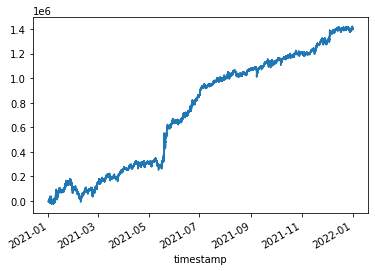

In [13]:
equity.plot()

<AxesSubplot:xlabel='timestamp'>

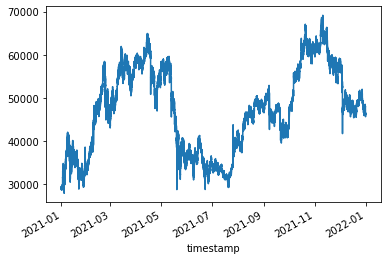

In [14]:
train['close'].plot()

<AxesSubplot:xlabel='timestamp'>

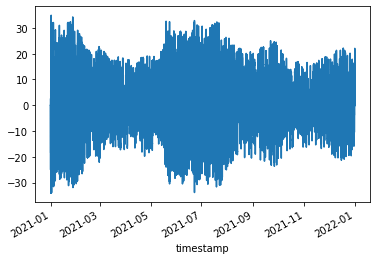

In [15]:
running_qty.plot()

In [16]:
def calc_cagr(begin, final, years):
    if final < 0:
        return (-1) * (((abs(final) + 2 * begin) / begin) ** (1 / years) - 1)
    else:
        return (final / begin) ** (1 / years) - 1

Start date            2021-01-01
End date              2021-12-31
Time period (days)           364
Sharpe Ratio            4.049701
CAGR                    1.411501
Max Daily Drawdown      0.147993
dtype: object


<AxesSubplot:>

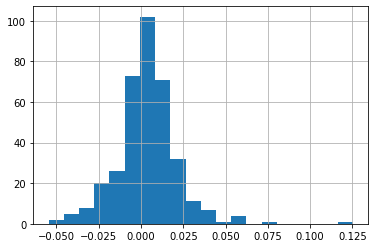

In [17]:
returns = equity.resample('1d').last().diff() / search.best_estimator_.max_position
# bm_returns = train['close'].resample('1d').last().pct_change()
# returns_ = returns - bm_returns
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(365)

equity_1d = equity.resample('1d').last()
Roll_Max = equity_1d.cummax()
Daily_Drawdown = (equity_1d - Roll_Max) / search.best_estimator_.max_position
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Sharpe Ratio': sr,
    'CAGR': calc_cagr(search.best_estimator_.max_position, search.best_estimator_.max_position + equity[-1], period / 365),
    'Max Daily Drawdown': -Max_Daily_Drawdown.min(),
}))

returns.hist(bins=20)

Start date                         2020-06-03
End date                           2022-09-01
Time period (days)                        819
Train period          2021-01-01 - 2021-12-31
Valid period          2020-06-03 - 2020-12-31
Sharpe ratio                         2.321014
CAGR                                 0.527055
RRR                                  1.358953
Maximum drawdown                     0.387839
dtype: object


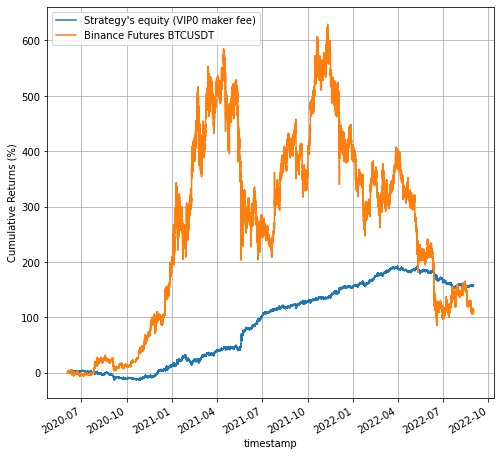

In [18]:
equity, running_qty = search.best_estimator_.predict(df.values)
equity = pd.Series(equity, index=df.index)
running_qty = pd.Series(running_qty, index=df.index)


returns = equity.resample('1d').last().diff() / search.best_estimator_.max_position
#bm_returns = valid['close'].resample('1d').last().pct_change()
#returns_ = returns - bm_returns
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(365)

equity_1d = equity.resample('1d').last()
Roll_Max = equity_1d.cummax()
Daily_Drawdown = (equity_1d - Roll_Max) / search.best_estimator_.max_position
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Train period': '%s - %s' % (train.index[0].strftime('%Y-%m-%d'), train.index[-1].strftime('%Y-%m-%d')),
    'Valid period': '%s - %s' % (valid.index[0].strftime('%Y-%m-%d'), valid.index[-1].strftime('%Y-%m-%d')),
    'Sharpe ratio': sr,
    'CAGR': calc_cagr(search.best_estimator_.max_position, search.best_estimator_.max_position + equity[-1], period / 365),
    'RRR': calc_cagr(search.best_estimator_.max_position, search.best_estimator_.max_position + equity[-1], period / 365) / -Max_Daily_Drawdown.min(),
    'Maximum drawdown': -Max_Daily_Drawdown.min(),
}))

# equity.resample('1d').last().pct_change().hist(bins=20)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
ax1 = (equity / search.best_estimator_.max_position * 100).plot()
ax2 = ((df['close'] / df['close'][0] - 1) * 100).plot()
ax1.set_ylabel('Cumulative Returns (%)')
ax1.legend(["Strategy's equity (VIP0 maker fee)", 'Binance Futures BTCUSDT'])
ax1.grid()

<AxesSubplot:xlabel='timestamp'>

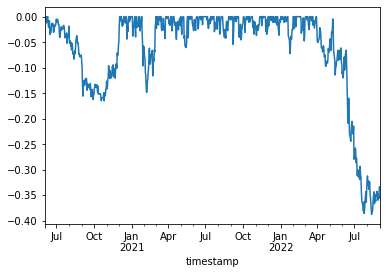

In [19]:
Daily_Drawdown.plot()

<AxesSubplot:xlabel='timestamp'>

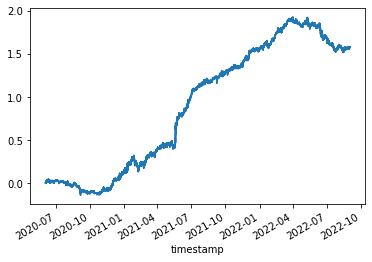

In [20]:
(equity / search.best_estimator_.max_position).plot()

In [21]:
equity.to_pickle("btcusdt-marketmaking-vip0")

In [22]:
# v2.4 params. Feb. 15, 2022
search.best_params_ = {
    'A': 27.523717761230337,
    'B': 73.23408011910584,
    'half_spread': 0.0009954163968328592,
    'imbalance': 12
}
search.best_estimator_.set_params(**search.best_params_)
search.best_estimator_.fee = 0

Start date                         2020-06-03
End date                           2022-09-01
Time period (days)                        819
Train period          2021-01-01 - 2021-12-31
Valid period          2020-06-03 - 2020-12-31
Sharpe ratio                         6.511029
CAGR                                 1.066526
RRR                                 13.794301
Maximum drawdown                     0.077316
dtype: object


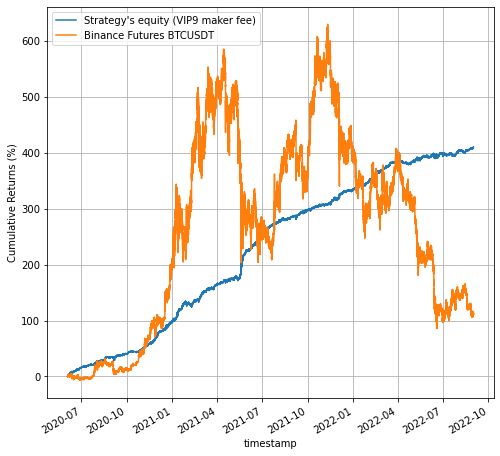

In [23]:
equity, running_qty = search.best_estimator_.predict(df.values)
equity = pd.Series(equity, index=df.index)
running_qty = pd.Series(running_qty, index=df.index)


returns = equity.resample('1d').last().diff() / search.best_estimator_.max_position
#bm_returns = valid['close'].resample('1d').last().pct_change()
#returns_ = returns - bm_returns
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(365)

equity_1d = equity.resample('1d').last()
Roll_Max = equity_1d.cummax()
Daily_Drawdown = (equity_1d - Roll_Max) / search.best_estimator_.max_position
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Train period': '%s - %s' % (train.index[0].strftime('%Y-%m-%d'), train.index[-1].strftime('%Y-%m-%d')),
    'Valid period': '%s - %s' % (valid.index[0].strftime('%Y-%m-%d'), valid.index[-1].strftime('%Y-%m-%d')),
    'Sharpe ratio': sr,
    'CAGR': calc_cagr(search.best_estimator_.max_position, search.best_estimator_.max_position + equity[-1], period / 365),
    'RRR': calc_cagr(search.best_estimator_.max_position, search.best_estimator_.max_position + equity[-1], period / 365) / -Max_Daily_Drawdown.min(),
    'Maximum drawdown': -Max_Daily_Drawdown.min(),
}))

# equity.resample('1d').last().pct_change().hist(bins=20)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
ax1 = (equity / search.best_estimator_.max_position * 100).plot()
ax2 = ((df['close'] / df['close'][0] - 1) * 100).plot()
ax1.set_ylabel('Cumulative Returns (%)')
ax1.legend(["Strategy's equity (VIP9 maker fee)", 'Binance Futures BTCUSDT'])
ax1.grid()

In [24]:
equity.to_pickle("btcusdt-marketmaking-vip9")